# Learning disentangled representations in a 'sphere-world' with continuous actions

## 1. Preamble

In [3]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random

import time
from IPython import display

try:
    import seaborn as sns
    sns.set()
    print("Set seaborn plotting defaults.")
except:
    print("seaborn not found.")

Set seaborn plotting defaults.


In [4]:
def mk_dir(export_dir, quite=False):
    if not os.path.exists(export_dir):
            try:
                os.makedirs(export_dir)
                print('created dir: ', export_dir)
            except OSError as exc: # Guard against race condition
                 if exc.errno != exc.errno.EEXIST:
                    raise
            except Exception:
                pass
    else:
        print('dir already exists: ', export_dir)

mk_dir("_data/")

dir already exists:  _data/


## 2. Defining objects

### SphereWorld environment

We use a cubic 3D world in which a ball evolves on a sphere. Observations are a 3-dimensional tensor with values 0 except at the voxel occupied by the ball which has value 1. When the ball is not at the center of the voxel (which is most of the time) its density is distributed around neighboring voxels. Actions are continuous rotations around the three axes.

In [5]:
class SphereWorld():
    
    class action_space():
        def __init__(self,n_actions):
            self.n = n_actions
            
        def sample(self, k=1):
            return torch.randint(0,self.n,(k,))       

    class observation_space():
        def __init__(self,n_features):
            self.shape = [n_features]
    
    def __init__(self,dim=5,radius=3.5):

        self.size = dim

        self.radius = radius
        self.action_space = self.action_space(6)
        self.observation_space = self.observation_space((2*dim)**3)
        
        self.reset()
        
    def reset(self):

        self.theta = random.uniform(0, np.pi)
        self.phi = random.uniform(0, np.pi*2)

        self.ball_coordinates = [self.radius*np.sin(self.theta)*np.cos(self.phi), \
                                 self.radius*np.sin(self.theta)*np.sin(self.phi), \
                                 self.radius*np.cos(self.theta)]   #Start from an outside position

        self.state = self.get_state()
        return self.get_observation()
    
    def get_state(self, ball_coordinates=None):
        if ball_coordinates is None:
            ball_coordinates=self.ball_coordinates

        state = torch.zeros((2*self.size, 2*self.size, 2*self.size))

        ball_low_x = ball_coordinates[0] + self.size - .5
        ball_low_y = ball_coordinates[1] + self.size - .5
        ball_low_z = ball_coordinates[2] + self.size - .5

        fill_x = (int(ball_low_x + 1) - ball_low_x)
        fill_y = (int(ball_low_y + 1) - ball_low_y)
        fill_z = (int(ball_low_z + 1) - ball_low_z)

        state[int(ball_low_x), int(ball_low_y), int(ball_low_z)] = fill_x * fill_y * fill_z
        state[(int(ball_low_x) + 1), int(ball_low_y), int(ball_low_z)] = (1 - fill_x) * fill_y * fill_z
        state[int(ball_low_x), (int(ball_low_y) + 1), int(ball_low_z)] = fill_x * (1 - fill_y) * fill_z
        state[(int(ball_low_x) + 1), (int(ball_low_y) +1), int(ball_low_z)] = (1 - fill_x) * (1 - fill_y) * fill_z
        state[int(ball_low_x), int(ball_low_y), int(ball_low_z) + 1] = fill_x * fill_y * (1 - fill_z)
        state[(int(ball_low_x) + 1), int(ball_low_y), int(ball_low_z) + 1] = (1 - fill_x) * fill_y * (1 - fill_z)
        state[int(ball_low_x), (int(ball_low_y) + 1), int(ball_low_z) + 1] = fill_x * (1 - fill_y) * (1 - fill_z)
        state[(int(ball_low_x) + 1), (int(ball_low_y) +1), int(ball_low_z) + 1] = (1 - fill_x) * (1 - fill_y) * (1 - fill_z)

        self.state = state
        return state      

    def get_observation(self):
        return self.state.flatten()

    def step(self, action, angle):

        ball_coordinates = self.ball_coordinates

        if action == 0:
            new_ball_coordinates = [ball_coordinates[0]*np.cos(angle) + ball_coordinates[1]*np.sin(angle), \
                                    - ball_coordinates[0]*np.sin(angle) + ball_coordinates[1]*np.cos(angle), \
                                    ball_coordinates[2]]
        elif action == 1:
            new_ball_coordinates = [ball_coordinates[0]*np.cos(angle) + ball_coordinates[2]*np.sin(angle), \
                                    ball_coordinates[1], \
                                    - ball_coordinates[0]*np.sin(angle) + ball_coordinates[2]*np.cos(angle)]
        elif action == 2:
            new_ball_coordinates = [ball_coordinates[0], \
                                    ball_coordinates[1]*np.cos(angle) + ball_coordinates[2]*np.sin(angle), \
                                    - ball_coordinates[1]*np.sin(angle) + ball_coordinates[2]*np.cos(angle)]
        else:
            raise Exception("INVALID ACTION")

        self.ball_coordinates = new_ball_coordinates
        self.state = self.get_state()
        return self.get_observation()

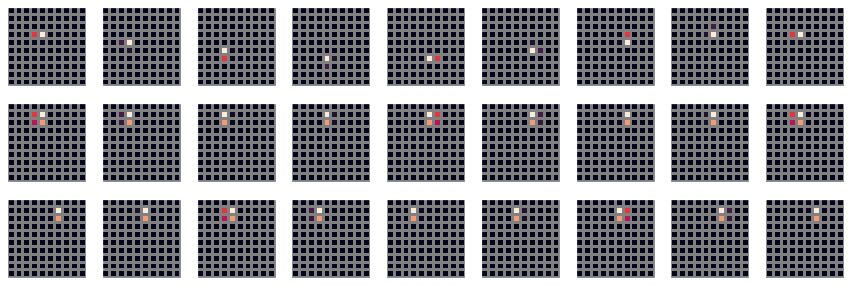

In [6]:
def plot_state(state, ax):
    ax[0].pcolormesh(env.state.sum(axis=0), edgecolors='gray', linewidth=2, )
    ax[0].set_aspect('equal')
    ax[0].set_xticks([])
    ax[0].set_yticks([])

    ax[1].pcolormesh(env.state.sum(axis=1), edgecolors='gray', linewidth=2, )
    ax[1].set_aspect('equal')
    ax[1].set_xticks([])
    ax[1].set_yticks([])

    ax[2].pcolormesh(env.state.sum(axis=2), edgecolors='gray', linewidth=2, )
    ax[2].set_aspect('equal')
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    
    return ax
    
n_steps = 8

env = SphereWorld()

fig, axs = plt.subplots(3, n_steps+1,figsize=(15, 5))

plot_state(env.state,axs[:,0])

for i in range(n_steps):
    action = 2
    env.step(action, np.pi/4)
    plot_state(env.state,axs[:,i+1])

### Latent space

**Encoder/Decoder**

Now we want to learn to represent this environment in some latent space (which we, for now, simply assume to be 3-dimensional).  We will require both an encoder and decoder.

In [7]:
class Coder(nn.Module):

    def __init__(self, n_in, n_out, n_hid=[16], output_activation=nn.Sigmoid):
        super().__init__()
        
        if type(n_hid) != list:
            n_hid = [n_hid]
        n_layers = [n_in] + n_hid + [n_out]

        self.layers = []
        for i_layer, (n1, n2) in enumerate(zip(n_layers, n_layers[1:])):
            mods = [nn.Linear(n1, n2, bias=True)]
            act_fn = nn.ReLU if i_layer < len(n_layers) - 2 else output_activation
            if act_fn is not None:
                mods.append(act_fn())
            layer = nn.Sequential(*mods)
            self.layers.append(layer)

        self.layers = nn.ModuleList(self.layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class nnNorm(nn.Module):
    
    def __init__(self, dim=-1):
        super().__init__()
        self.dim=dim
        
    def forward(self, x):
        return F.normalize(x, dim=self.dim)
    
class Decoder(Coder):

    def __init__(self, n_in, n_out, n_hid=[32]):
        super().__init__(n_in, n_out, n_hid, output_activation=nn.Sigmoid)
        
class Encoder(Coder):

    def __init__(self, n_in, n_out, n_hid=[32]):
        super().__init__(n_in, n_out, n_hid, output_activation=nnNorm)

class Angles(Coder):

    def __init__(self, n_in, n_out, n_hid=[32]):
        super().__init__(n_in, n_out, n_hid, output_activation=None)



In [8]:
encoder = Encoder(n_in=5*5*5, n_out=6, n_hid=[16])
print(encoder)

decoder = Decoder(n_in=6, n_out=5*5*5, n_hid=[16])
print(decoder)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(encoder)

Encoder(
  (layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=125, out_features=16, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=16, out_features=6, bias=True)
      (1): nnNorm()
    )
  )
)
Decoder(
  (layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=6, out_features=16, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=16, out_features=125, bias=True)
      (1): Sigmoid()
    )
  )
)


2118

**Check tensor dimensions**

In [9]:
x = torch.rand(125)
z = encoder(x)
x_recon = decoder(z)
print("Observable rep (shape = {}) : \n {}".format(x.shape, x))
print("Latent rep (shape = {}, norm = {}) : \n {}".format(z.shape, torch.norm(z), z))
print("Reconstructed Observable rep (shape = {}) : \n {}".format(x_recon.shape, x_recon))

Observable rep (shape = torch.Size([125])) : 
 tensor([0.7465, 0.3080, 0.6728, 0.6707, 0.2601, 0.5539, 0.2608, 0.1451, 0.9772,
        0.1851, 0.9757, 0.7232, 0.9828, 0.0409, 0.1499, 0.5088, 0.7317, 0.2052,
        0.4871, 0.9581, 0.8763, 0.5830, 0.9491, 0.2963, 0.6474, 0.6051, 0.6445,
        0.0425, 0.8856, 0.6241, 0.6790, 0.6623, 0.1144, 0.0890, 0.2951, 0.4601,
        0.1984, 0.2154, 0.2393, 0.5368, 0.8392, 0.7534, 0.8539, 0.3853, 0.6711,
        0.1581, 0.0553, 0.7864, 0.0143, 0.0531, 0.6825, 0.0017, 0.0765, 0.6904,
        0.0106, 0.5519, 0.7424, 0.5537, 0.1419, 0.5953, 0.2058, 0.0273, 0.7198,
        0.5424, 0.4027, 0.3631, 0.9479, 0.7090, 0.4094, 0.3788, 0.8239, 0.1186,
        0.8091, 0.8597, 0.0639, 0.0113, 0.1291, 0.5800, 0.2463, 0.4774, 0.8501,
        0.3880, 0.2150, 0.3972, 0.0666, 0.5490, 0.9660, 0.9858, 0.0052, 0.5190,
        0.4252, 0.4801, 0.4965, 0.1412, 0.1996, 0.3487, 0.7313, 0.3509, 0.1360,
        0.7507, 0.7039, 0.0814, 0.5088, 0.9698, 0.1575, 0.3549, 0.5117, 0

**Representation**

The crux of the matter is learning to 'represent' actions in the observation space with actions in latent space.  Here, we will do this by assuming every action is a generalized rotation in latent space, which we denote with a series of 2-dimensional rotations.

A 2-d rotation is given by:

\begin{pmatrix}
\cos(\theta) & \sin(\theta) \\
-\sin(\theta) & \cos(\theta)
\end{pmatrix}

and we denote a rotation in dimensions $i$ and $j$ of a higher dimensional space as $R_{i,j}(\theta)$.  For $i=1$, $j=4$, in a 4-dimensional space:

\begin{equation}
R_{1,4}(\theta) = 
\begin{pmatrix}
\cos(\theta) & 0 & 0 & \sin(\theta) \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
-\sin(\theta) & 0 & 0 & \cos(\theta)
\end{pmatrix}
\end{equation}

An arbitrary rotation, denoted $g$ as I am subtly moving towards this being a group action, can then be written as:

\begin{equation}
    g(\theta_{1,2},\theta_{1,3},\dots,\theta_{n-1,n}) = \prod_{i=1}^{n-1} \prod_{j=1+1}^{n} R_{i,j}(\theta_{i,j})
\end{equation}

which has $n(n-1)/2$ free parameters (i.e. $\theta_{i,j}$'s).

To learn continuous Lie groups instead of discrete rotations, each of these $\theta_{i,j}$ is now parameterized by a neural network.

In [10]:
class Representation():

    def __init__(self, dim=3):
        self.dim = dim
        self.params = dim*(dim-1)//2
        self.thetas = torch.autograd.Variable(torch.rand(self.params), requires_grad=True)

        self.__matrix = None
    
    def set_thetas(self, thetas):
        self.thetas = thetas
        self.clear_matrix()
    
    def clear_matrix(self):
        self.__matrix = None
        
    def get_matrix(self):
        if self.__matrix is None:
            k = 0
            mats = []
            for i in range(self.dim-1):
                for j in range(self.dim-1-i):
                    theta_ij = self.thetas[k]
                    k+=1
                    c, s = torch.cos(theta_ij), torch.sin(theta_ij)

                    rotation_i = torch.eye(self.dim, self.dim)
                    rotation_i[i, i] = c
                    rotation_i[i, i+j+1] = s
                    rotation_i[j+i+1, i] = -s
                    rotation_i[j+i+1, j+i+1] = c

                    mats.append(rotation_i)

            def chain_mult(l):
                if len(l)>=3:
                    return l[0]@l[1]@chain_mult(l[2:])
                elif len(l)==2:
                    return l[0]@l[1]
                else:
                    return l[0]

            self.__matrix = chain_mult(mats)
                                    
        return self.__matrix

**LatentWorld**

Now, for symmetry's sake, we'll also have a `LatentWorld` which acts as the environment in the latent space.

In [11]:
class LatentWorld():
    
    class action_space():
        def __init__(self,n_actions):
            self.n = n_actions
            
        def sample(self, k=1):
            return torch.randint(0,self.n,(k,))

    class observation_space():
        def __init__(self,n_features):
            self.shape = [n_features]
    
    def __init__(self,
                 dim=3,
                 n_actions=3,
                 n_hid=[64]):

        self.dim = dim
        self.angle_computer = Angles(n_in = 2, n_out = dim*(dim-1)//2, n_hid=n_hid)
        self.action_space = self.action_space(n_actions)
        self.observation_space = self.observation_space(dim)
        
        self.representation = Representation()
        
    def reset(self, state):
        self.state = state
        return self.get_observation()
    
    def clear_representations(self):
        self.representation.clear_matrix()
            
    def get_representation_params(self):
        params = []
        for rep in self.action_reps:
            params.append(rep.thetas)
        return params
    
    def save_representations(self, path):
        if os.path.splitext(path)[-1] != '.pth':
            path += '.pth'
        return torch.save(self.angle_computer.state_dict(), path)
    
    def load_reprentations(self, path):
        self.representation.load_state_dict(torch.load(path))
            
    def get_observation(self):
        return self.state
    
    def step(self,action_value):
        self.representation.set_thetas(self.angle_computer(action_value))
        self.state = torch.mv(self.representation.get_matrix(), self.state)
        obs = self.get_observation()
        return obs

## 5. Disentanglement

***Some jargon***

We focus on learning a *disentangled* representation of the actions.

Before considering how best to do this, we want to define a metric of 'disentanglement'.  We consider the evolution of an observable (latent) vector, $x \in X$ ($z \in Z$), under the element $g \in G$ of the group of symmetries generating transformations of the object.  Then we are looking for a representation, $\rho:G \rightarrow GL(V)$, such that the transformation is linear in the latent space, i.e.
\begin{equation}
    z^{\prime} = \rho(g) \cdot z.
\end{equation}
Note, in our case, the representations are the rotation matrices we learn.

For this representation to be disentangled, it means that if there exists a subgroup decomposition of $G$
\begin{equation}
    G = G_1 \times G_2 \times \dots \times G_n,
\end{equation}
then we equivalently decompose the representation, $(\rho, G)$, into subrepresentations:
\begin{equation}
    V = V_1 \oplus V_2 \oplus \dots \oplus V_n
\end{equation}
such that the restricted subrepresentations $(\rho_{\vert G_i}, V_i)_i$ are non-trivial, and the restricted subrepresentations $(\rho_{\vert G_i}, V_j)_{j \neq i}$ are trivial.

In our context, a SphereWorld can be represented as a subgroup of $\mathrm{SO}(3)$, therefore we hope to find the disentangled representation of the three continuous rotations.

***Some practicalities***

Our intuition is that the disentangled representation acts as the identity on as many dimensions as possible.  We could attempt to enforce this with some regularization during training.  Normal weight decay won't cut it, as that tries to reduce all weights, where as what we really want to do is have all *but one* of our thetas (which corresponds to the rotation/coupling of two dimensions) to be zero.

**1. Entanglement regularisation**

So for $m$ parameters, ${\theta_1, \dots, \theta_m}$, we want to regularise with
\begin{equation}
    \sum_{i \neq j} \vert\theta_i\vert^2, \mathrm{where\ } \theta_j {=} \mathrm{max_k}({\vert\theta_k\vert}).
\end{equation}
We will also use this term as our metric of 'entanglement'.

In [12]:
def calc_entanglement(params):
    params = params.abs().pow(2)
    return params.sum() - params.max()

params = torch.FloatTensor([1,1,0.5,0,0])
calc_entanglement(params)

tensor(1.2500)

### Training

In [13]:
obs_env = SphereWorld(dim = 5, radius = 4.)
lat_env = LatentWorld(dim = 3,
                      n_actions = obs_env.action_space.n
                     )
decoder = Decoder(n_in = sum(lat_env.observation_space.shape),
                  n_out = sum(obs_env.observation_space.shape),
                  n_hid = [64])

encoder = Encoder(n_in = sum(obs_env.observation_space.shape),
                  n_out = sum(lat_env.observation_space.shape),
                  n_hid = [64])

optimizer_dec = optim.Adam(decoder.parameters(),
                           lr=1e-2,
#                            betas=(0.9, 0.99),
                           weight_decay=0)

optimizer_enc = optim.Adam(encoder.parameters(),
                           lr=1e-2,
#                            betas=(0.9, 0.99),
                           weight_decay=0)

optimizer_rep = optim.Adam(lat_env.angle_computer.parameters(),
                           lr=1e-2,
#                            betas=(0.9, 0.99),
                           weight_decay=0)

losses = []


In [14]:
n_sgd_steps = 10000
ep_steps = 5
batch_eps = 8

#Starting by learning small angles before moving on the larger angles helps
angle_max = np.pi * 2 / 5

i = 1

t_start = time.time()

temp = 0

while i < n_sgd_steps:
    if i == 4000:
        angle_max = np.pi * 4 / 5
    if i == 7000:
        angle_max = np.pi

    loss = torch.zeros(1)
    
    for _ in range(batch_eps):
        t_ep = -1
        while t_ep < ep_steps:
            angle = random.uniform(-angle_max, angle_max)
            if t_ep == -1:
                obs_x = obs_env.reset()
                obs_z = lat_env.reset(encoder(obs_x))
            else:
                action = random.randrange(3)
                obs_x = obs_env.step(action, angle)
                obs_z = lat_env.step(torch.tensor([action, angle]))
            
            t_ep += 1         
            
            obs_x_recon = decoder(obs_z)
            (obs_x_recon==obs_x_recon.max()).float()

            loss += F.binary_cross_entropy(obs_x_recon, obs_x)
            loss += calc_entanglement(lat_env.angle_computer(torch.tensor([action, angle])))*1e-3


    loss /= (batch_eps * ep_steps)
    loss_raw = loss

    losses.append(loss_raw.item())

    optimizer_dec.zero_grad()
    optimizer_rep.zero_grad()
    optimizer_enc.zero_grad()
    loss.backward()
    optimizer_dec.step()
    optimizer_rep.step()
    optimizer_enc.step()
        
    # Rember to clear the cached action representations after we update the parameters!
    lat_env.clear_representations()

    i+=1
    
    if i%10==0:
        print("iter {} : loss={:.5f} : last 10 iters in {:.3f}s".format(
            i, loss.item(), time.time() - t_start
            ), end="\r" if i%100 else "\n")
        t_start = time.time()

iter 100 : loss=0.00873 : last 10 iters in 0.956s
iter 200 : loss=0.00840 : last 10 iters in 0.998s
iter 300 : loss=0.00837 : last 10 iters in 1.157s
iter 400 : loss=0.00827 : last 10 iters in 1.201s
iter 500 : loss=0.00833 : last 10 iters in 0.954s
iter 600 : loss=0.00839 : last 10 iters in 0.978s
iter 700 : loss=0.00818 : last 10 iters in 0.881s
iter 800 : loss=0.00736 : last 10 iters in 0.885s
iter 900 : loss=0.00769 : last 10 iters in 1.069s
iter 1000 : loss=0.00776 : last 10 iters in 0.882s
iter 1100 : loss=0.00755 : last 10 iters in 0.900s
iter 1200 : loss=0.00808 : last 10 iters in 0.860s
iter 1300 : loss=0.00797 : last 10 iters in 0.859s
iter 1400 : loss=0.00731 : last 10 iters in 0.873s
iter 1500 : loss=0.00709 : last 10 iters in 0.995s
iter 1600 : loss=0.00729 : last 10 iters in 1.008s
iter 1700 : loss=0.00607 : last 10 iters in 1.166s
iter 1800 : loss=0.00549 : last 10 iters in 0.997s
iter 1900 : loss=0.00500 : last 10 iters in 0.996s
iter 2000 : loss=0.00457 : last 10 iters

In [16]:
exp_name = "ent_reg_1e-2_orthNorm_reg_1e-2_20steps_16batch"
# exp_name = "testing"

save_folder = os.path.join("_data/decoder_only", exp_name)
train_folder = os.path.join(save_folder,"train")
test_folder = os.path.join(save_folder,"test")

mk_dir(save_folder)
mk_dir(train_folder)
mk_dir(test_folder)

dir already exists:  _data/decoder_only/ent_reg_1e-2_orthNorm_reg_1e-2_20steps_16batch
dir already exists:  _data/decoder_only/ent_reg_1e-2_orthNorm_reg_1e-2_20steps_16batch/train
dir already exists:  _data/decoder_only/ent_reg_1e-2_orthNorm_reg_1e-2_20steps_16batch/test


**Plot training curve**

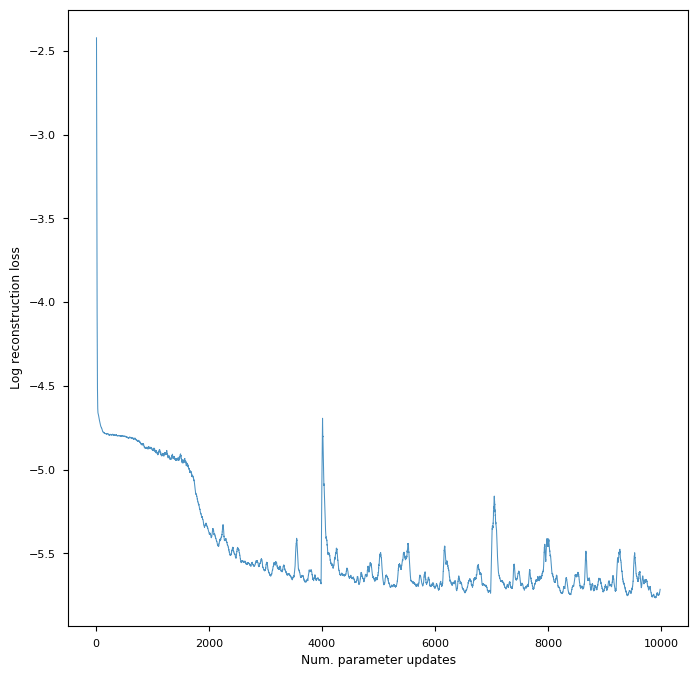

In [17]:
with plt.style.context('seaborn-paper', after_reset=True):

    fig, (ax1) = plt.subplots(1, 1, figsize=(8, 8), gridspec_kw={"wspace":0.3})

    window = 25
    avg_mask = np.ones(window) / window

    ax1.plot(np.convolve(range(len(losses)), avg_mask, 'valid'),
             np.convolve(np.log(losses), avg_mask, 'valid'),
             linewidth=0.75,
             alpha=0.8)
#     ax1.set_yscale("log")

    ax1.set_xlabel("Num. parameter updates")
    ax1.set_ylabel("Log reconstruction loss")
    
    fig_fname = os.path.join(train_folder, "training_curves")
    plt.savefig(fig_fname + ".pdf", bbox_inches='tight')
    plt.savefig(fig_fname + ".png", bbox_inches='tight')

In [19]:
torch.save(decoder.state_dict(), os.path.join(save_folder,"decoder.pth"))
torch.save(optimizer_dec.state_dict(), os.path.join(train_folder,"optimizer_dec.pth"))
torch.save(optimizer_rep.state_dict(), os.path.join(train_folder,"optimizer_rep.pth"))

### Testing

**1) Representations learned for specific values of the rotations**

tensor([-0.0141, -1.2666, -0.0347])
tensor([-0.0108, -0.6385, -0.0200])
tensor([ 0.0065, -0.0003, -0.0070])
tensor([ 0.0114,  0.6367, -0.0090])
tensor([-0.0018,  1.2439, -0.0116])
tensor([ 1.2568, -0.0076, -0.0137])
tensor([ 0.6322, -0.0027, -0.0052])
tensor([-0.0007,  0.0007,  0.0004])
tensor([-0.6170, -0.0037,  0.0082])
tensor([-1.2276, -0.0047,  0.0082])
tensor([ 0.0278, -0.0084, -1.2709])
tensor([ 0.0195, -0.0058, -0.6343])
tensor([ 0.0408, -0.0020,  0.0335])
tensor([ 0.0255, -0.0036,  0.6596])
tensor([ 0.0439, -0.0054,  1.3084])


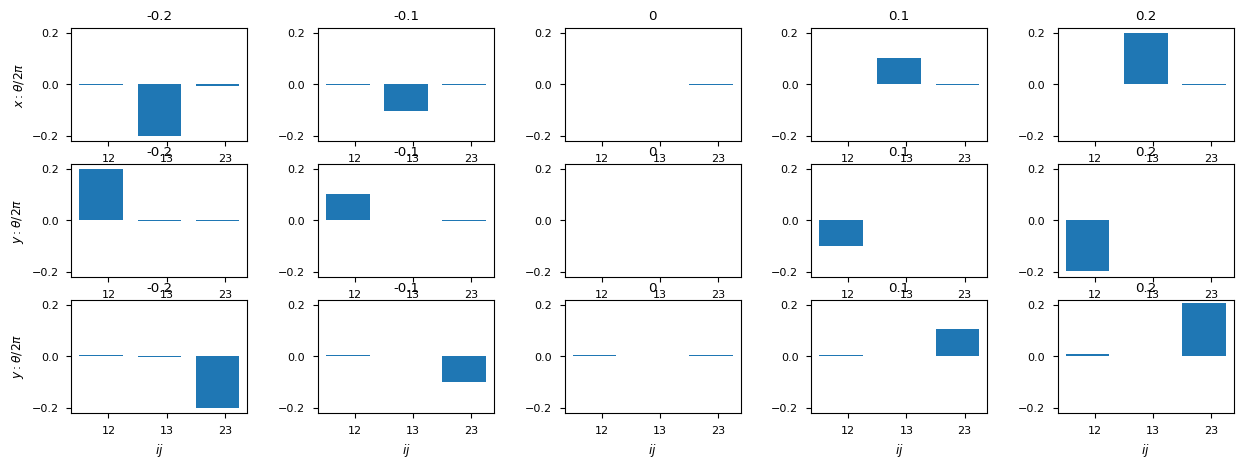

In [20]:
width=0.75


plt_lim = 0.22
titles = ["-0.2", "-0.1", "0", "0.1", "0.2"]

with plt.style.context('seaborn-paper', after_reset=True):

    fig, axs = plt.subplots(3, 5, figsize=(15, 5), gridspec_kw={"wspace":0.4})
    
    for i in range(15):
        thetas = lat_env.angle_computer(torch.tensor([i//5, (-0.2+(i%5)/10.)*2*np.pi])).detach()
        print(thetas)
        x = np.arange(len(thetas))
        axs[i//5,i%5].bar(x - width/2, thetas/(2*np.pi), width, label='Rep {}'.format(i))
        
        axs[i//5,i%5].set_yticks([-0.2, 0., 0.2])
        axs[i//5,i%5].set_xticks(x-0.25)
        axs[i//5,i%5].set_xticklabels(["12","13","23"])
        axs[i//5,i%5].set_xlabel("$ij$")
        
        axs[i//5,i%5].set_ylim(-plt_lim,plt_lim)
        
        axs[i//5,i%5].set_title(titles[i%5])
        
    axs[0,0].set_ylabel(r"$x : \theta / 2\pi$" )
    axs[1,0].set_ylabel(r"$y : \theta / 2\pi$" )
    axs[2,0].set_ylabel(r"$y : \theta / 2\pi$" )    

    fig_fname = os.path.join(test_folder, "thetas")

    plt.savefig(fig_fname + ".pdf", bbox_inches='tight')
    plt.savefig(fig_fname + ".png", bbox_inches='tight')

**2) Learned representations as a function of rotation angle**

/home/william/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


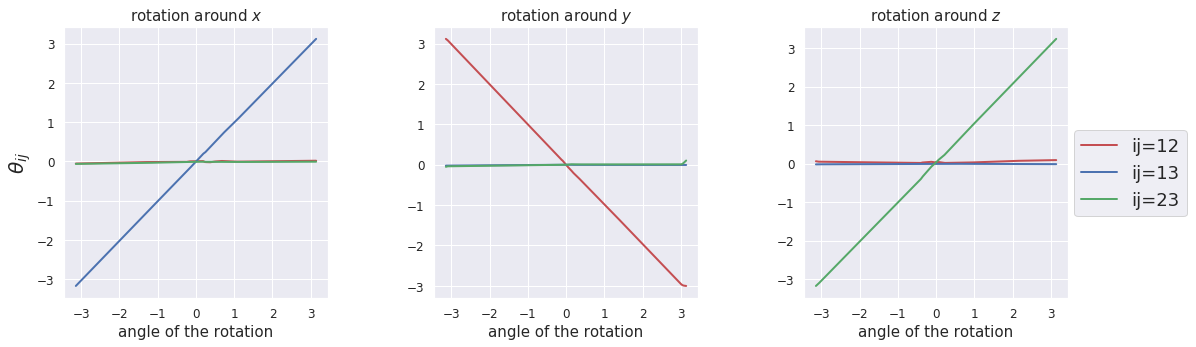

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5), gridspec_kw={"wspace":0.4})

x = np.linspace(-np.pi, np.pi, 500)

titles = ["rotation around $x$", "rotation around $y$", "rotation around $z$"]

for i in range(3):
    y0 = []
    y1 = []
    y2 = []
    for k in range(500):
        y = lat_env.angle_computer(torch.tensor([i, x[k]])).detach().numpy()
        y0 += [y[0]]
        y1 += [y[1]]
        y2 += [y[2]]
    a = axs[i].plot(x,y0,c="r",linewidth=2)[0]
    b = axs[i].plot(x,y1,c="b",linewidth=2)[0]
    c = axs[i].plot(x,y2,c="g",linewidth=2)[0]
    axs[i].set_xlabel("angle of the rotation", fontsize=15)
    axs[i].set_title(titles[i], fontsize=15)
    axs[i].tick_params(labelsize=12)
axs[0].set_ylabel(r"$\theta_{ij}$", fontsize=20)
fig.legend((a,b,c),(r'ij=12',r'ij=13',r'ij=23'),loc="center right", fontsize=18)
fig.show()



**3) See predictions made by network**

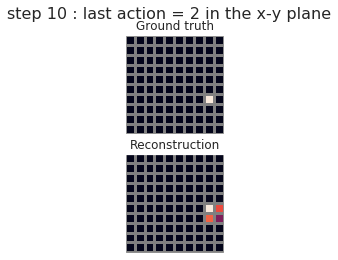

In [22]:
def plot_state(obs, ax, one_hot=True):
    if one_hot:
        obs=(obs == obs.max())
    ax.pcolormesh(obs.reshape(2*obs_env.size, 2*obs_env.size, 2*obs_env.size).sum(axis=2), edgecolors='gray', linewidth=2)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    
    return ax
    
n_steps = 10

fig, (ax1,ax2) = plt.subplots(2, 1)

ax1.set_title("Ground truth")
ax2.set_title("Reconstruction")

for i in range(n_steps+1):
    
    if i==0:
        action = "N\A"
        obs_x = obs_env.reset()
        obs_z = lat_env.reset(encoder(obs_x))
    else:
        action = random.randrange(3)
        angle = random.uniform(-angle_max, angle_max)
        obs_x = obs_env.step(action, angle)
        obs_z = lat_env.step(torch.tensor([action, angle]))
        
    obs_x_recon = decoder(obs_z)
    
    fig.suptitle('step {} : last action = {} in the x-y plane'.format(i, action), fontsize=16)
    
    plot_state(obs_x.detach().numpy(),ax1)
    plot_state(obs_x_recon.detach().numpy(),ax2, one_hot=False)
    
    fig_fname = os.path.join(test_folder, "step_{}".format(i))

    plt.savefig(fig_fname + ".pdf", bbox_inches='tight')
    plt.savefig(fig_fname + ".png", bbox_inches='tight')
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(1.)
    
display.clear_output(wait=False)